### Task 1:<br>
#### part 1

C:\Users\Samin Naji\AppData\Local\Temp\ipykernel_13716\714422603.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  eeg_rate = float(data["EEG"][0, 0]["srate"][0])
C:\Users\Samin Naji\AppData\Local\Temp\ipykernel_13716\714422603.py:37: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  win = hann(win_length)
C:\Users\Samin Naji\AppData\Local\Temp\ipykernel_13716\714422603.py:44: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  win = hann(len(trial))


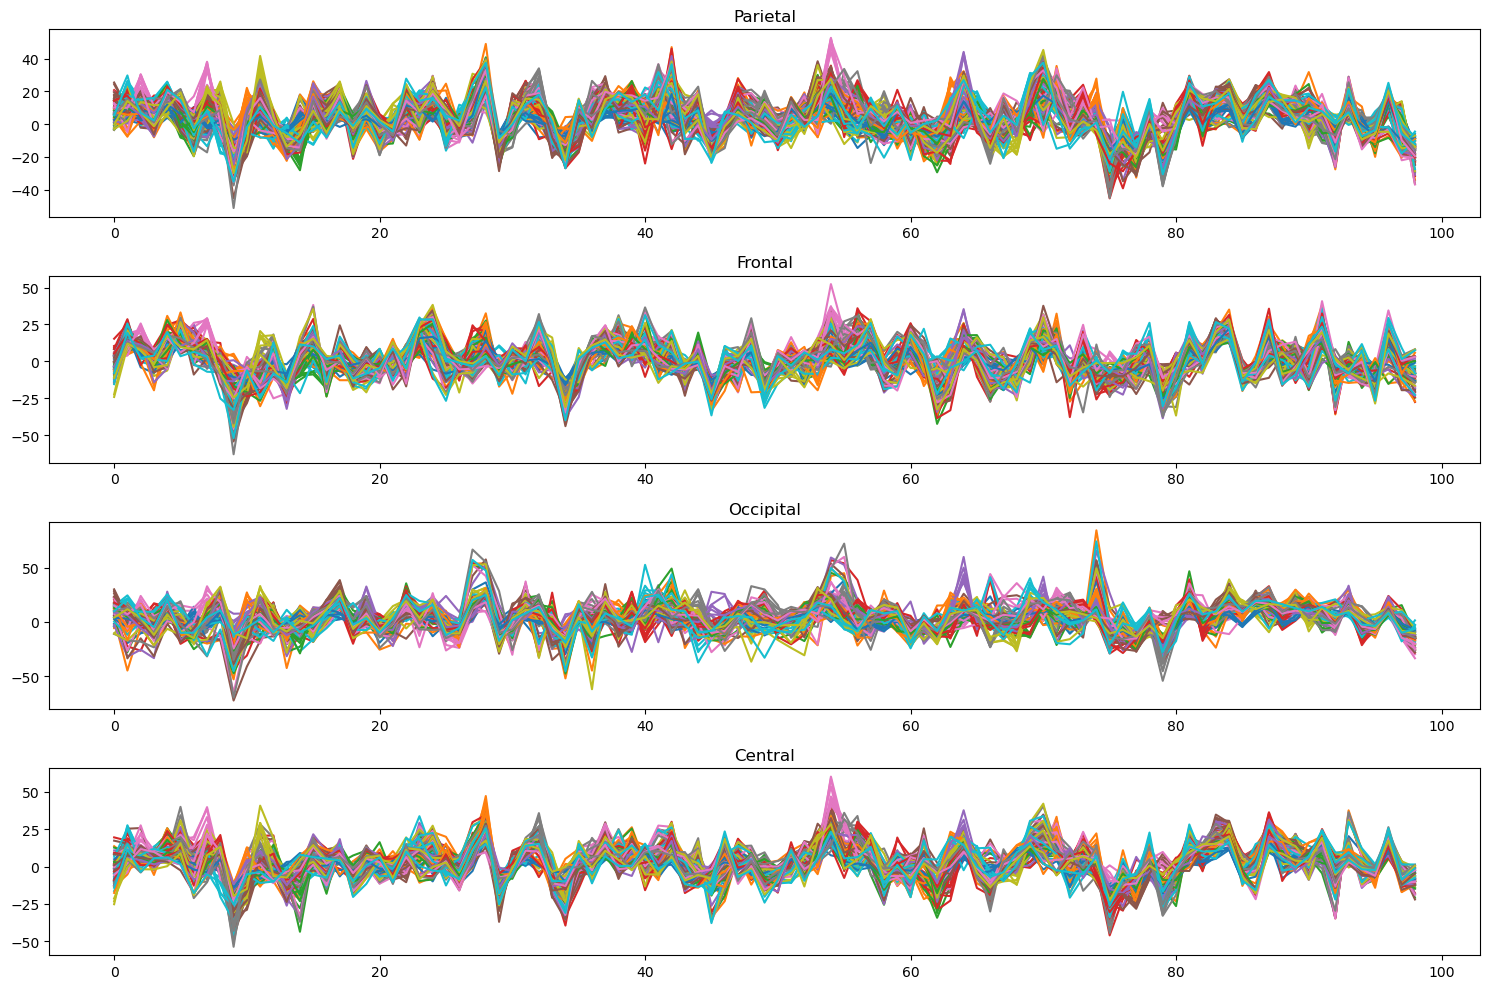

In [1]:
import scipy.io
import numpy as np
from scipy.signal import hann, butter, filtfilt
import matplotlib.pyplot as plt

# Load the data
data = scipy.io.loadmat('sampleEEGdata.mat')

# Extract relevant information from the EEG file
eeg_data = data["EEG"][0, 0]["data"]
eeg_pts = data["EEG"][0, 0]["pnts"][0, 0]
eeg_times = data["EEG"][0, 0]["times"][0]
eeg_rate = float(data["EEG"][0, 0]["srate"][0])
eeg_trials = data["EEG"][0, 0]["trials"][0, 0]
eeg_epoch = data["EEG"][0, 0]["epoch"][0]
eeg_chan_locs_labels = data["EEG"][0, 0]["chanlocs"][0]["labels"]

# Map of electrode types to labels
electrode_types = {
    "Parietal": ['P1', 'P3', 'P5', 'P7', 'P9', 'Pz', 'CP1', 'CP3', 'CP5', 'CPz'],
    "Frontal": ['Fp1', 'F1', 'F3', 'F5', 'F7', 'Fz', 'AF3', 'AF7', 'AFz'],
    "Occipital": ['O1', 'Oz', 'O2', 'Iz', 'PO3', 'PO7', 'POz'],
    "Central": ['C1', 'C3', 'C5', 'Cz', 'C2', 'C4', 'C6']
}

# Extract 10 trials for each electrode type
extracted_trials = {}
for e_type, labels in electrode_types.items():
    extracted_trials[e_type] = []
    for label in labels:
        # Find the index of the channel with the corresponding label
        channel_index = np.where(np.array(eeg_chan_locs_labels) == label)[0][0]
        extracted_trials[e_type].extend(eeg_data[channel_index, :10].tolist())

# Preprocessing
win_length = 640
win = hann(win_length)
b, a = butter(4, [0.5, 30], btype='band', fs=640)

for e_type in extracted_trials:
    for trial in extracted_trials[e_type]:
        # Ensure the length of the Hann window matches the trial length
        if len(win) != len(trial):
            win = hann(len(trial))
        
        trial = trial * win  # Apply Hann window
        trial = filtfilt(b, a, trial)  # Apply Butterworth filter


# Plotting
plt.figure(figsize=(15, 10))
for i, e_type in enumerate(extracted_trials):
    for trial in extracted_trials[e_type]:
        plt.subplot(len(extracted_trials), 1, i + 1)
        plt.plot(trial)
        plt.title(e_type)
plt.tight_layout()
plt.show()

### Task 1:<br>
#### part 2

C:\Users\Samin Naji\AppData\Local\Temp\ipykernel_13716\1389158086.py:14: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  win = hann(win_length)
C:\Users\Samin Naji\AppData\Local\Temp\ipykernel_13716\1389158086.py:23: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  win = hann(len(trial))


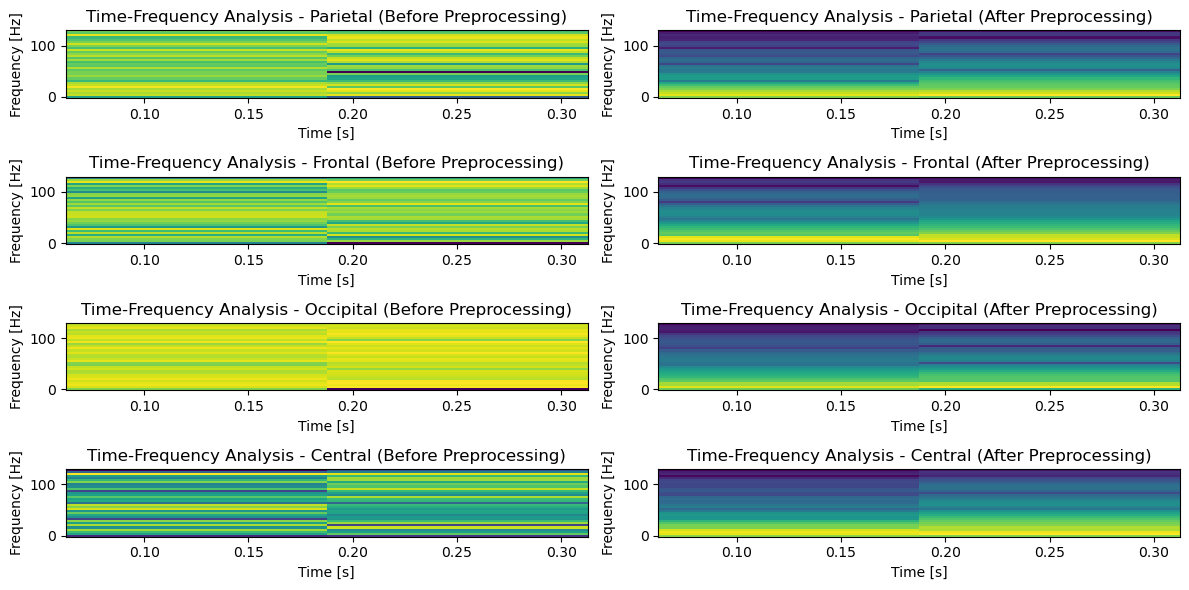

In [2]:
from scipy.signal import spectrogram

# Extract all trials for each electrode type
all_trials = {}
for e_type, labels in electrode_types.items():
    all_trials[e_type] = []
    for label in labels:
        # Find the index of the channel with the corresponding label
        channel_index = np.where(np.array(eeg_chan_locs_labels) == label)[0][0]
        all_trials[e_type].extend(eeg_data[channel_index, :, :].tolist())

# Preprocessing
win_length = 640
win = hann(win_length)
b, a = butter(4, [0.5, 30], btype='band', fs=640)

preprocessed_trials = {}
for e_type in all_trials:
    preprocessed_trials[e_type] = []
    for trial in all_trials[e_type]:
        # Ensure the length of the Hann window matches the trial length
        if len(win) != len(trial):
            win = hann(len(trial))
        
        trial = trial * win  # Apply Hann window
        trial = filtfilt(b, a, trial)  # Apply Butterworth filter
        preprocessed_trials[e_type].append(trial)

# Average trials
average_trials = {e_type: np.mean(np.array(preprocessed_trials[e_type]), axis=0) for e_type in preprocessed_trials}

# Time-frequency analysis before preprocessing
plt.figure(figsize=(12, 6))
for i, e_type in enumerate(all_trials):
    f, t, Sxx = spectrogram(np.mean(np.array(all_trials[e_type]), axis=0), fs=eeg_rate, nperseg=64, noverlap=32)
    plt.subplot(len(all_trials), 2, 2*i+1)
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='auto')
    plt.title(f'Time-Frequency Analysis - {e_type} (Before Preprocessing)')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')

# Time-frequency analysis after preprocessing
for i, e_type in enumerate(preprocessed_trials):
    f, t, Sxx = spectrogram(average_trials[e_type], fs=eeg_rate, nperseg=64, noverlap=32)  # Decreased overlap
    plt.subplot(len(preprocessed_trials), 2, 2*i+2)
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='auto')
    plt.title(f'Time-Frequency Analysis - {e_type} (After Preprocessing)')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')

plt.tight_layout()
plt.show()

### Task 2:

C:\Users\Samin Naji\AppData\Local\Temp\ipykernel_13716\2517911698.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


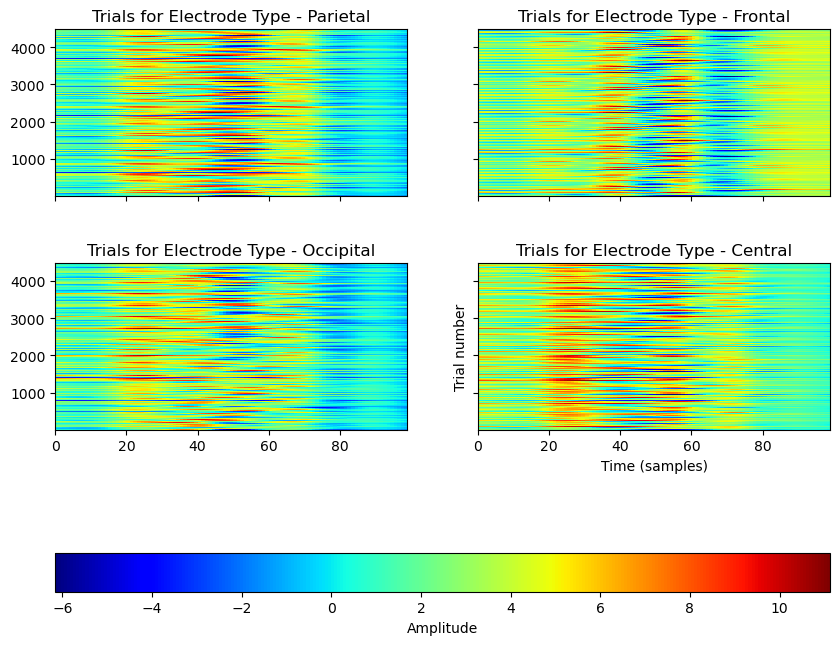

In [3]:
from matplotlib import gridspec

# Assuming preprocessed_trials contains your preprocessed EEG data
# The structure is preprocessed_trials[electrode_type][trial_index]

# Specify the threshold for detecting stimulus onset
threshold = 0.5  # Adjust this value based on your data characteristics

# Function to detect stimulus onset in a single trial
def detect_onset(trial, threshold):
    trial_array = np.asarray(trial)  # Convert to NumPy array
    if np.issubdtype(trial_array.dtype, np.number):  # Check if the data is numeric
        onset_indices = np.where(trial_array > threshold)[0]
        return onset_indices
    else:
        # Handle non-numeric data (e.g., strings) here if needed
        # You may want to print or log a message, or take a specific action
        print("Non-numeric data encountered in trial.")
        return []

# Convert list of trials to a NumPy array
preprocessed_trials_array = {e_type: np.array(trials) for e_type, trials in preprocessed_trials.items()}

# Create a subplot grid with 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True, gridspec_kw={'hspace': 0.4})

# Flatten the axs array for easy indexing
axs = axs.flatten()

# Detect stimulus onset for each trial and plot
for i, (e_type, trials) in enumerate(preprocessed_trials_array.items()):
    rts = np.zeros_like(trials)
    for j, trial in enumerate(trials):
        onset_indices = detect_onset(trial, threshold)
        if len(onset_indices) > 0:
            rts[j] = onset_indices[0] / eeg_rate  # Convert to time in seconds
    
    # Sort trials based on RTs
    rts_idx = np.argsort(rts)

    im = axs[i].imshow(
        np.vstack(trials[rts_idx]),
        extent=[0, trials.shape[1], 1, trials.shape[0]],
        aspect="auto",
        cmap=plt.get_cmap("jet"),
        origin="lower",
        interpolation="none"
    )

    axs[i].set_title(f"Trials for Electrode Type - {e_type}")

# Add a colorbar below the subplots
cbar = fig.colorbar(im, ax=axs, orientation='horizontal', pad=0.2)
cbar.set_label("Amplitude")

# Adjust layout
plt.xlabel("Time (samples)")
plt.ylabel("Trial number")
plt.tight_layout()
plt.show()

### Task 3:

C:\Users\Samin Naji\AppData\Local\Temp\ipykernel_13716\595579646.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


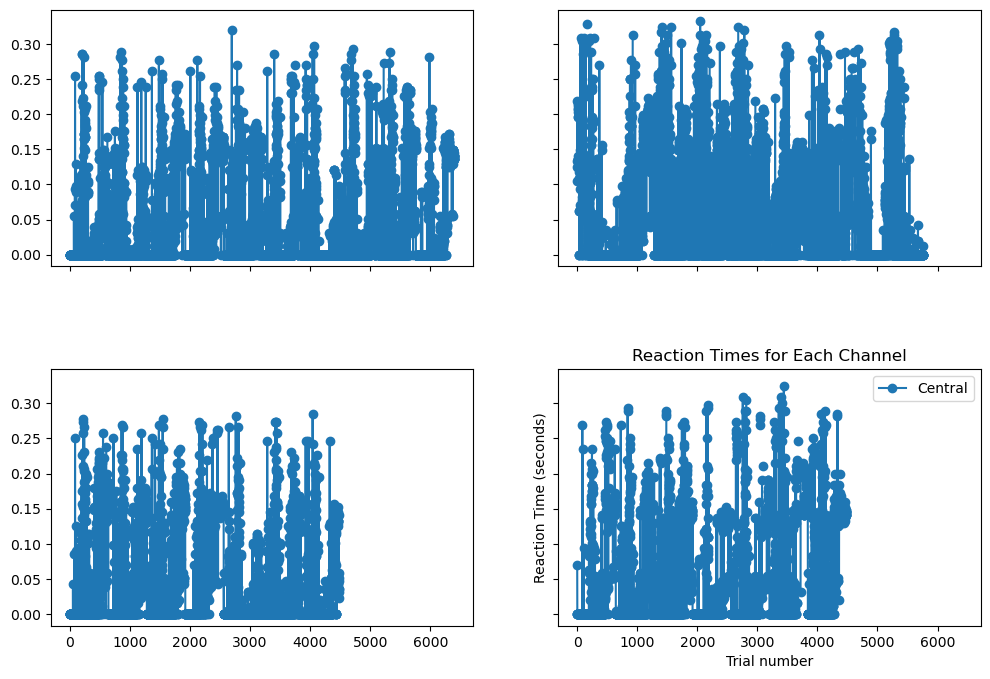

In [4]:
from matplotlib import gridspec

# Assuming preprocessed_trials contains your preprocessed EEG data
# The structure is preprocessed_trials[electrode_type][trial_index]

# Specify the threshold for detecting stimulus onset
threshold = 0.5  # Adjust this value based on your data characteristics

# Function to detect stimulus onset in a single trial
def detect_onset(trial, threshold):
    trial_array = np.asarray(trial)  # Convert to NumPy array
    if np.issubdtype(trial_array.dtype, np.number):  # Check if the data is numeric
        onset_indices = np.where(trial_array > threshold)[0]
        return onset_indices
    else:
        # Handle non-numeric data (e.g., strings) here if needed
        # You may want to print or log a message, or take a specific action
        print("Non-numeric data encountered in trial.")
        return []

# Convert list of trials to a NumPy array
preprocessed_trials_array = {e_type: np.array(trials) for e_type, trials in preprocessed_trials.items()}

# Create a subplot grid with 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True, gridspec_kw={'hspace': 0.4})

# Flatten the axs array for easy indexing
axs = axs.flatten()

# Detect stimulus onset for each trial and calculate reaction time
reaction_times = {e_type: [] for e_type in preprocessed_trials_array.keys()}
for i, (e_type, trials) in enumerate(preprocessed_trials_array.items()):
    for j, trial in enumerate(trials):
        onset_indices = detect_onset(trial, threshold)
        if len(onset_indices) > 0:
            reaction_time = onset_indices[0] / eeg_rate  # Convert to time in seconds
            reaction_times[e_type].append(reaction_time)
        else:
            reaction_times[e_type].append(np.nan)  # Set NaN for trials with no onset

    # Plot the reaction times for each channel
    axs[i].plot(reaction_times[e_type], marker='o', linestyle='-', label=f"{e_type}")

axs[i].set_title("Reaction Times for Each Channel")
axs[i].set_xlabel("Trial number")
axs[i].set_ylabel("Reaction Time (seconds)")
axs[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()

### Task 4:

C:\Users\Samin Naji\AppData\Local\Temp\ipykernel_13716\2962966685.py:71: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_coords = np.array([float(chanloc['X'][0]) for chanloc in data['chanlocs']])
C:\Users\Samin Naji\AppData\Local\Temp\ipykernel_13716\2962966685.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_coords = np.array([float(chanloc['Y'][0]) for chanloc in data['chanlocs']])


Error plotting topomap for PC1: Data and pos need to be of same length. Got data of length 64, pos of length 1
Error plotting topomap for PC2: Data and pos need to be of same length. Got data of length 64, pos of length 1
Error plotting topomap for PC3: Data and pos need to be of same length. Got data of length 64, pos of length 1
Error plotting topomap for PC4: Data and pos need to be of same length. Got data of length 64, pos of length 1
Error plotting topomap for PC5: Data and pos need to be of same length. Got data of length 64, pos of length 1
Error plotting topomap for PC6: Data and pos need to be of same length. Got data of length 64, pos of length 1
Error plotting topomap for PC7: Data and pos need to be of same length. Got data of length 64, pos of length 1
Error plotting topomap for PC8: Data and pos need to be of same length. Got data of length 64, pos of length 1
Error plotting topomap for PC9: Data and pos need to be of same length. Got data of length 64, pos of length 1
E

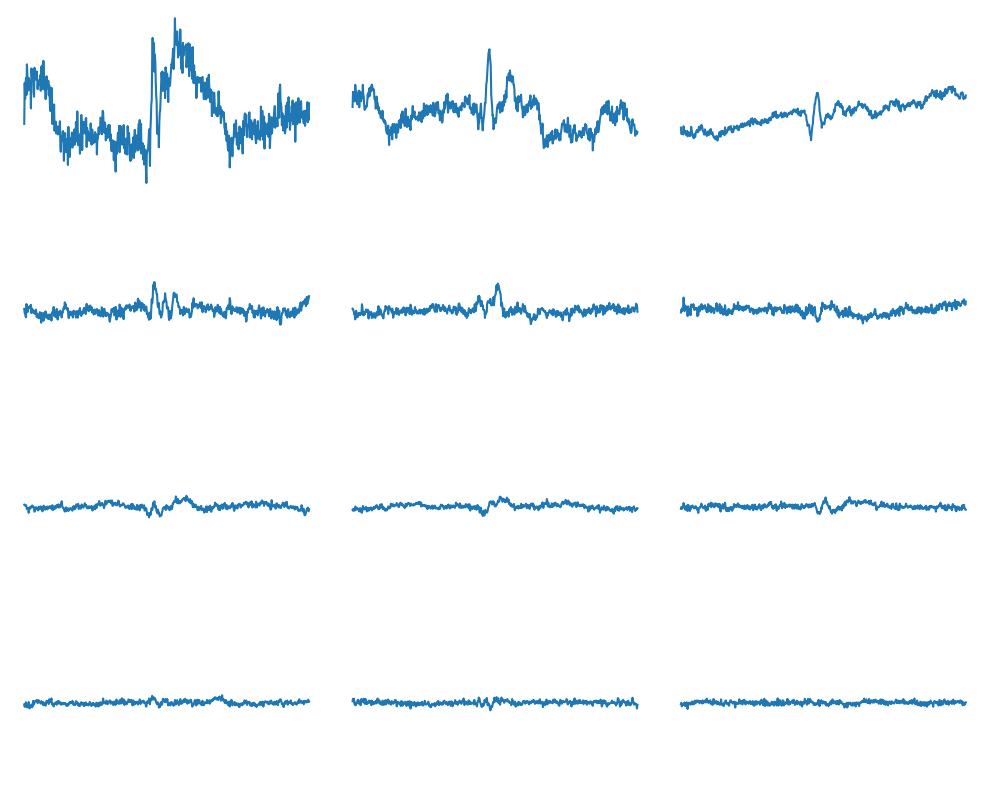

Error plotting topomap for PC1: Data and pos need to be of same length. Got data of length 64, pos of length 1
Error plotting topomap for PC2: Data and pos need to be of same length. Got data of length 64, pos of length 1
Error plotting topomap for PC3: Data and pos need to be of same length. Got data of length 64, pos of length 1
Error plotting topomap for PC4: Data and pos need to be of same length. Got data of length 64, pos of length 1
Error plotting topomap for PC5: Data and pos need to be of same length. Got data of length 64, pos of length 1
Error plotting topomap for PC6: Data and pos need to be of same length. Got data of length 64, pos of length 1
Error plotting topomap for PC7: Data and pos need to be of same length. Got data of length 64, pos of length 1
Error plotting topomap for PC8: Data and pos need to be of same length. Got data of length 64, pos of length 1
Error plotting topomap for PC9: Data and pos need to be of same length. Got data of length 64, pos of length 1
E

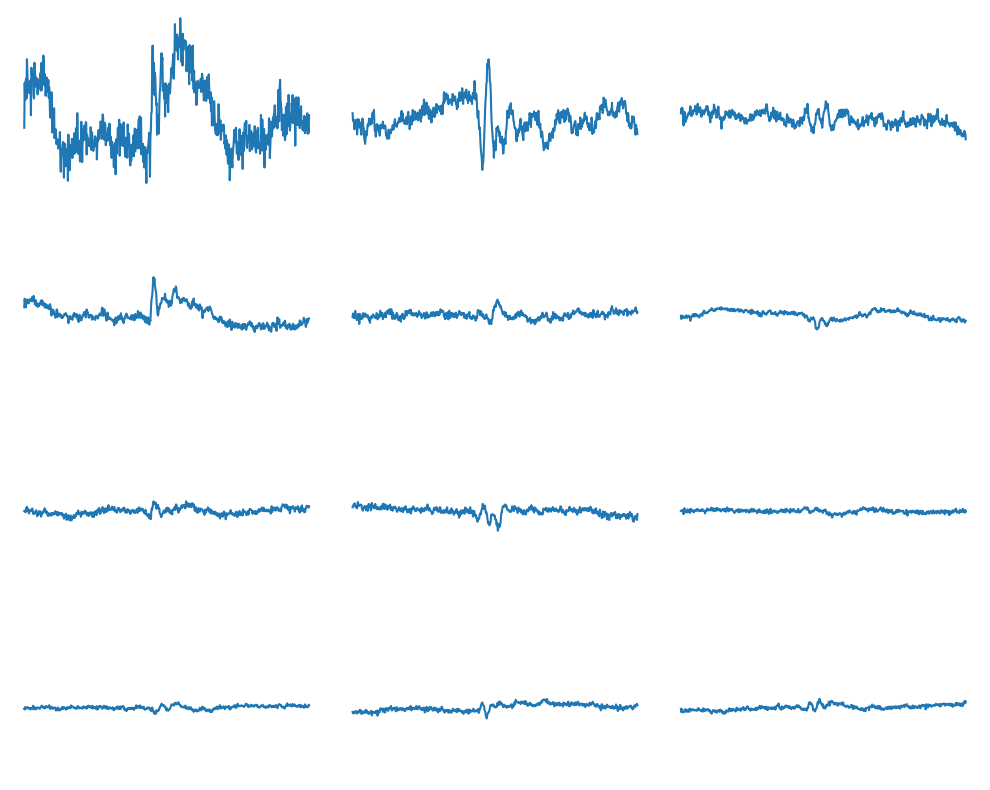

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import scipy.io

def load_data(file_path):
    data = scipy.io.loadmat(file_path)
    return data["EEG"][0, 0]

def compute_erp_pca(erp_data):
    erp = erp_data.mean(2)
    erp_min_mean = erp - erp.mean(axis=1)[:, np.newaxis]
    covar_erp = (erp @ erp.T) / (erp_data.shape[1] - 1)
    eig_val_erp, eig_erp = np.linalg.eig(covar_erp)
    pc_erp = eig_erp.T @ erp_min_mean
    var_explained_erp = 100 * eig_val_erp / eig_val_erp.sum()
    return pc_erp, eig_erp, var_explained_erp

def compute_single_trial_pca(eeg_data):
    covar_trial = np.zeros([eeg_data.shape[0], eeg_data.shape[0], eeg_data.shape[2]])
    eeg_min_mean = np.zeros_like(eeg_data)

    for ii in range(eeg_data.shape[2]):
        for jj in range(eeg_data.shape[0]):
            eeg_min_mean[jj, :, ii] = eeg_data[jj, :, ii] - eeg_data[jj, :, ii].mean()

        covar_trial[..., ii] = np.cov(eeg_min_mean[..., ii])

    covar = np.mean(covar_trial, axis=2)
    eig_val, eig = np.linalg.eig(covar)

    pc_trial = np.zeros_like(eeg_min_mean)
    for ii in range(eeg_data.shape[2]):
        pc_trial[..., ii] = eig.T @ eeg_min_mean[..., ii]

    pc = pc_trial.mean(2)
    var_explained = 100 * eig_val / eig_val.sum()

    return pc, eig, var_explained



def plot_results(pc, eig, var_explained, coords_2d, nrows, ncols):
    fig, ax = plt.subplots(nrows, ncols, figsize=[10, 8], sharey=True, tight_layout=True)

    num_pcs = min(pc.shape[0], nrows * ncols)

    for ii in range(num_pcs):
        row = ii // ncols
        col = ii % ncols

        ax[row, col].plot(pc[ii])
        ax[row, col].set_axis_off()

        # Check if eig is non-empty before plotting the topomap
        if eig.size > 0 and ii < eig.shape[1]:
            try:
                mne.viz.plot_topomap(eig[:, ii], coords_2d, axes=ax[row, col], show=False)
                ax[row, col].set_title(f"PC{ii + 1}: {var_explained[ii]:.1f}%")
            except ValueError as e:
                print(f"Error plotting topomap for PC{ii + 1}: {e}")

    plt.show()



# Load data
data = load_data('sampleEEGdata.mat')

# Extract channel locations
x_coords = np.array([float(chanloc['X'][0]) for chanloc in data['chanlocs']])
y_coords = np.array([float(chanloc['Y'][0]) for chanloc in data['chanlocs']])
coords_2d = np.column_stack((x_coords, y_coords))

# Compute and plot ERP PCA
erp_pc, erp_eig, erp_var_explained = compute_erp_pca(data['data'])
plot_results(erp_pc, erp_eig, erp_var_explained, coords_2d, nrows=4, ncols=3)

# Compute and plot single-trial EEG PCA
trial_pc, trial_eig, trial_var_explained = compute_single_trial_pca(data['data'])
plot_results(trial_pc, trial_eig, trial_var_explained, coords_2d, nrows=4, ncols=3)

### Task 5:

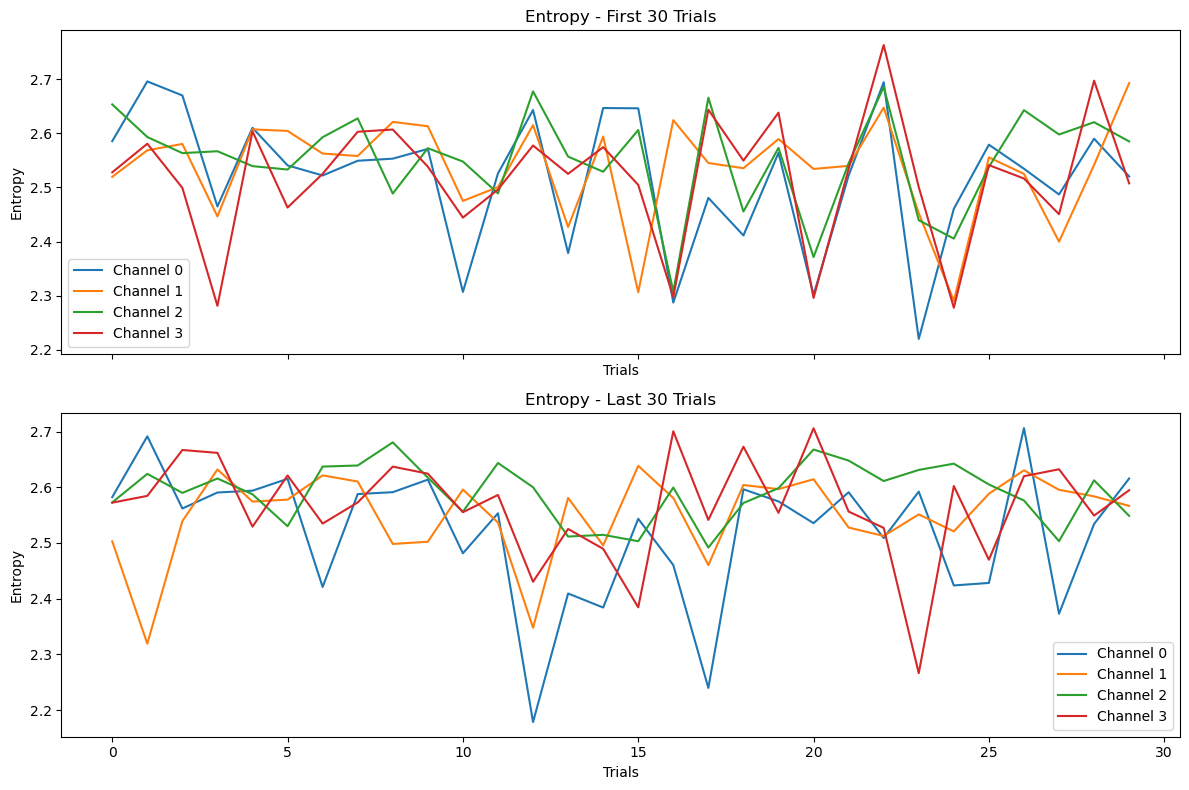

In [46]:
from scipy.stats import entropy

# Function to compute entropy for a given set of trials and channels
def compute_entropy(trials, channels):
    entropy_values = np.zeros((len(channels), trials.shape[2]))

    for i, channel in enumerate(channels):
        for j in range(trials.shape[2]):
            hist, _ = np.histogram(trials[channel, :, j], bins='auto', density=True)
            entropy_values[i, j] = entropy(hist)

    return entropy_values

# Extract channel indices for the channels you are interested in
selected_channels = [0, 1, 2, 3]

# Select the first and last 30 trials
first_30_trials = data['data'][:, :, :30]
last_30_trials = data['data'][:, :, -30:]

# Compute entropy for the selected channels and trials
entropy_first_30 = compute_entropy(first_30_trials, selected_channels)
entropy_last_30 = compute_entropy(last_30_trials, selected_channels)

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot entropy for the first 30 trials
axes[0].plot(entropy_first_30.T)
axes[0].set_title('Entropy - First 30 Trials')
axes[0].set_xlabel('Trials')
axes[0].set_ylabel('Entropy')
axes[0].legend([f'Channel {ch}' for ch in selected_channels])

# Plot entropy for the last 30 trials
axes[1].plot(entropy_last_30.T)
axes[1].set_title('Entropy - Last 30 Trials')
axes[1].set_xlabel('Trials')
axes[1].set_ylabel('Entropy')
axes[1].legend([f'Channel {ch}' for ch in selected_channels])

plt.tight_layout()
plt.show()
